In [1]:
with open('pg_engine.txt') as f:
    pg_engine = f.readlines()
from sqlalchemy import create_engine
engine = create_engine(pg_engine[0])

In [2]:
import pandas as pd
df = pd.read_sql_query('select * from "rental_listings"',con=engine)

In [3]:
print(df.dtypes)
df.describe()


pid              object
date             object
region           object
neighborhood     object
rent            float64
bedrooms        float64
sqft            float64
rent_sqft       float64
longitude       float64
latitude        float64
county           object
fips_block       object
state            object
dtype: object


,rent,bedrooms,sqft,rent_sqft,longitude,latitude
count,4.480110e+05,448011.000000,448011.000000,4.480110e+05,448011.000000,448011.000000
mean,1.324332e+04,1.895056,1094.916411,4.055081e+01,-95.405249,36.677134
std,4.541611e+06,0.989025,4263.581249,1.733293e+04,16.696323,5.458671
min,1.000000e+00,0.000000,1.000000,5.555556e-05,-159.530300,-84.507816
25%,8.500000e+02,1.000000,750.000000,8.785942e-01,-111.865691,32.865566
50%,1.199000e+03,2.000000,960.000000,1.201878e+00,-93.657300,36.505317
75%,1.701000e+03,2.000000,1200.000000,1.790541e+00,-81.210247,40.396479
max,2.147484e+09,10.000000,999999.000000,1.100120e+07,0.000000,165.383045


In [4]:
upper_percentile = 0.998
lower_percentile = 0.002

# how many rows would be within the upper and lower percentiles?
upper = int(len(df) * upper_percentile)
lower = int(len(df) * lower_percentile)

# get the rent/sqft values at the upper and lower percentiles
rent_sqft_sorted = df['rent_sqft'].sort_values(ascending=True, inplace=False)
upper_rent_sqft = rent_sqft_sorted.iloc[upper]
lower_rent_sqft = rent_sqft_sorted.iloc[lower]

# get the rent values at the upper and lower percentiles
rent_sorted = df['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = df['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent_sqft range:', [lower_rent_sqft, upper_rent_sqft])
print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent_sqft range: [0.090742438130155798, 11.4772727272727]
valid rent range: [99.0, 11000.0]
valid sqft range: [210.0, 4687.0]


In [5]:
# create a boolean vector mask to filter out any rows with rent_sqft outside of the reasonable values
rent_sqft_mask = (df['rent_sqft'] > lower_rent_sqft) & (df['rent_sqft'] < upper_rent_sqft)

# create boolean vector masks to filter out any rows with rent or sqft outside of the reasonable values
rent_mask = (df['rent'] > lower_rent) & (df['rent'] < upper_rent)
sqft_mask = (df['sqft'] > lower_sqft) & (df['sqft'] < upper_sqft)

# filter the thorough listings according to these masks
filtered_listings = pd.DataFrame(df[rent_sqft_mask & rent_mask & sqft_mask])
len(filtered_listings)

444392

In [7]:
sfbay = filtered_listings[filtered_listings['region']=='sfbay']
sfbay.describe()

,rent,bedrooms,sqft,rent_sqft,longitude,latitude
count,14355.000000,14355.000000,14355.000000,14355.000000,14355.000000,14355.000000
mean,2916.830164,1.822083,1047.595333,3.024046,-122.125741,37.644953
std,1195.983192,1.006514,493.453015,1.082870,1.038054,0.336421
min,175.000000,0.000000,212.000000,0.182927,-123.773900,32.621140
25%,2150.000000,1.000000,720.000000,2.344639,-122.390753,37.382125
50%,2645.000000,2.000000,950.000000,2.842027,-122.093800,37.663004
75%,3398.000000,2.000000,1202.000000,3.541667,-121.962029,37.801083
max,10950.000000,7.000000,4645.000000,10.801887,-87.453600,47.587437


In [8]:
geocoded = pd.read_csv('data/craigslist_data_wblockid.csv', dtype={'GEOID10': object}).rename(columns={'GEOID10':'fips_block'})

In [9]:
print(geocoded.columns)
geocoded.describe()

Index(['index', 'pid', 'date', 'region', 'neighborhood', 'rent', 'bedrooms',
       'sqft', 'rent_sqft', 'rent_sqft_cat', 'longitude', 'latitude', 'geom',
       'fips_block'],
      dtype='object')


/Users/Paul/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,index,pid,rent,bedrooms,sqft,rent_sqft,rent_sqft_cat,longitude,latitude
count,1.367142e+06,1.367142e+06,1.367142e+06,1.301693e+06,1.367142e+06,1.367142e+06,1.367142e+06,1.367142e+06,1.367142e+06
mean,7.330246e+05,4.502898e+09,1.340748e+03,2.047311e+00,1.074148e+03,1.352719e+00,2.980504e+00,-1.012379e+02,3.708709e+01
std,4.206196e+05,3.252243e+07,8.156975e+02,9.272406e-01,5.103953e+02,7.836169e-01,1.388046e+00,1.789768e+01,5.336504e+00
min,0.000000e+00,4.417508e+09,1.900000e+02,1.000000e+00,2.210000e+02,1.004464e-01,1.000000e+00,-1.644361e+02,1.904303e+01
25%,3.685862e+05,4.477738e+09,7.990000e+02,NaN,7.500000e+02,8.279793e-01,2.000000e+00,-1.179548e+02,3.354999e+01
50%,7.363475e+05,4.496396e+09,1.115000e+03,NaN,9.620000e+02,1.096681e+00,3.000000e+00,-1.047681e+02,3.707657e+01
75%,1.096559e+06,4.530615e+09,1.650000e+03,NaN,1.214000e+03,1.661392e+00,4.000000e+00,-8.338839e+01,4.033090e+01
max,1.456337e+06,4.574744e+09,1.028500e+04,8.000000e+00,5.192000e+03,1.260504e+01,5.000000e+00,-6.702982e+01,6.591511e+01


In [10]:
geocoded[:10]

,index,pid,date,region,neighborhood,rent,bedrooms,sqft,rent_sqft,rent_sqft_cat,longitude,latitude,geom,fips_block
0,0,4454264047,2014-05-11,santabarbara,NaN,3500.0,3.0,1200.0,2.916667,5,-119.726987,34.399757,0101000020E61000007F677BF486EE5DC06DACC43C2B33...,060830013048000
1,1,4437398427,2014-05-11,santabarbara,6533 Trigo Road,850.0,2.0,882.0,0.963719,2,-119.855845,34.411019,0101000020E61000007D5C1B2AC6F65DC06F8445459C34...,060830029242004
2,2,4437286111,2014-05-11,santabarbara,downtown,2795.0,3.0,1200.0,2.329167,5,-119.712193,34.413942,0101000020E61000002BDCF29194ED5DC06D382C0DFC34...,060830012031000
3,3,4465598705,2014-05-11,santabarbara,santa barbara,5000.0,3.0,2000.0,2.500000,5,-119.692343,34.431691,0101000020E610000054A703594FEC5DC0207D93A64137...,060830006002000
4,4,4465561098,2014-05-11,santabarbara,Lompoc,1330.0,2.0,1000.0,1.330000,4,-120.469315,34.703429,0101000020E61000006C21C841091E5EC06C0723F6095A...,060830028084014
5,5,4465459067,2014-05-11,santabarbara,256 Mathilda drive,1375.0,1.0,650.0,2.115385,5,-119.886525,34.428311,0101000020E610000088855AD3BCF85DC02FC214E5D236...,060830029304000
6,6,4465454916,2014-05-11,santabarbara,255 Ellwood Beach drive,1375.0,1.0,650.0,2.115385,5,-119.885960,34.428245,0101000020E61000001B649291B3F85DC078D66EBBD036...,060830029304000
7,7,4428556398,2014-05-11,santabarbara,Santa Barbara,2400.0,2.0,850.0,2.823529,5,-119.669995,34.418522,0101000020E6100000F25EB532E1EA5DC00954FF209235...,060830008041005
8,9,4465408945,2014-05-11,santabarbara,"Lompoc, CA",850.0,1.0,644.0,1.319876,4,-120.461958,34.650227,0101000020E6100000098849B8901D5EC0F4FC69A33A53...,060830027052010
9,10,4450609529,2014-05-11,santabarbara,Storke Ranch,6000.0,4.0,2229.0,2.691790,5,-119.862235,34.418558,0101000020E6100000DC9DB5DB2EF75DC056BDFC4E9335...,060830029225000


In [11]:
sfbay_geocoded = geocoded[geocoded['region']=='sfbay']
sfbay_geocoded.describe()

/Users/Paul/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,index,pid,rent,bedrooms,sqft,rent_sqft,rent_sqft_cat,longitude,latitude
count,7.176700e+04,7.176700e+04,71767.000000,67161.000000,71767.000000,71767.000000,71767.000000,71767.000000,71767.000000
mean,8.761931e+05,4.515081e+09,2529.436663,1.909218,1026.495311,2.654153,4.733903,-122.113709,37.643169
std,4.053274e+05,3.043084e+07,1104.966850,0.918099,503.167676,0.948447,0.617483,0.415524,0.345550
min,6.064000e+03,4.419377e+09,285.000000,1.000000,221.000000,0.140476,1.000000,-157.845039,21.290814
25%,5.658775e+05,4.487801e+09,1835.000000,NaN,722.000000,2.054945,5.000000,-122.283936,37.378580
50%,9.502680e+05,4.518829e+09,2325.000000,NaN,903.000000,2.578947,5.000000,-122.047200,37.586396
75%,1.261562e+06,4.541766e+09,2954.000000,NaN,1152.000000,3.111111,5.000000,-121.952200,37.844122
max,1.450750e+06,4.567896e+09,10250.000000,8.000000,5157.000000,10.611888,5.000000,-70.690600,47.577915


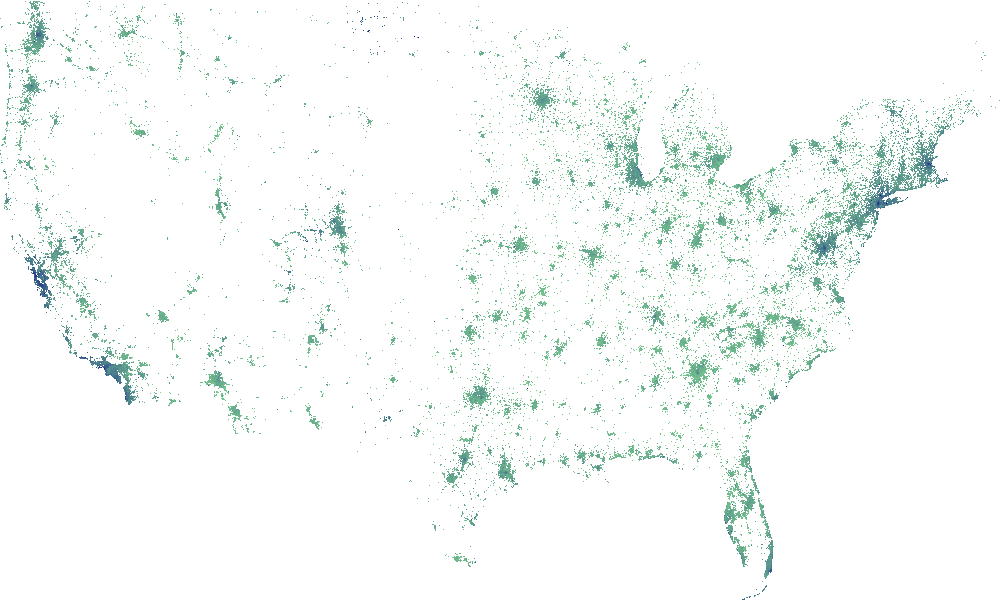

In [15]:
import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd

US_XMin = -124.848974
US_XMax = -66.885444

US_YMin = 24.396308
US_YMax = 49.384358

geocoded = geocoded[(geocoded['longitude']>US_XMin) & (geocoded['longitude']<US_XMax)]
geocoded = geocoded[(geocoded['latitude']>US_YMin) & (geocoded['latitude']<US_YMax)]

cvs = ds.Canvas(plot_width=1000, plot_height=600)
agg = cvs.points(geocoded, 'longitude', 'latitude', ds.mean('rent_sqft'))
img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')
img

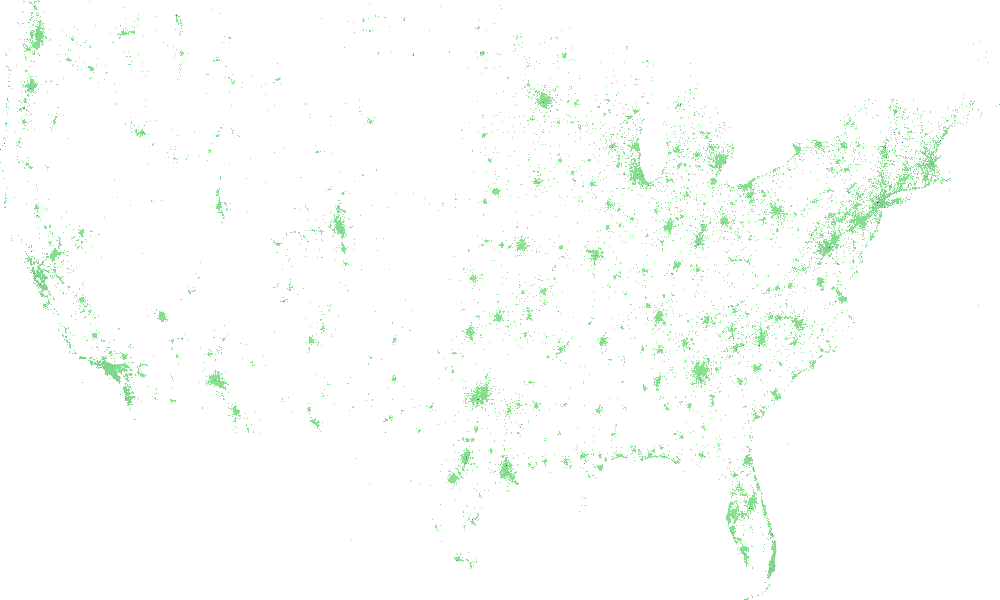

In [13]:
df = df[(df['longitude']>US_XMin) & (df['longitude']<US_XMax)]
df = df[(df['latitude']>US_YMin) & (df['latitude']<US_YMax)]

cvs = ds.Canvas(plot_width=1000, plot_height=600)
agg = cvs.points(df, 'longitude', 'latitude', ds.mean('rent_sqft'))
img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')
img

In [17]:
import datashader as ds 
import datashader.transfer_functions as tf
from datashader.colors import Greys9, Hot, colormap_select as cm 
def bg(img): return tf.set_background(img,"black")

In [18]:
USA = ((-124.848974, -66.885444), (24.396308, 49.384358))
 
x_range,y_range = USA
 
plot_width = int(900)
plot_height = int(plot_width*7.0/12)

In [19]:
def create_image(x_range, y_range, w=plot_width, h=plot_height, spread=0):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'meterswest', 'metersnorth', ds.count_cat('race'))
    img = tf.colorize(agg, color_key, how='eq_hist')
    if spread: img = tf.spread(img,px=spread)
    return tf.set_background(img,"black")

In [20]:
import bokeh.plotting as bp
from bokeh.models.tiles import WMTSTileSource
 
bp.output_notebook()
 
def base_plot(tools='pan,wheel_zoom,reset',webgl=False):
     p = bp.figure(tools=tools,
         plot_width=int(900), plot_height=int(500),
         x_range=x_range, y_range=y_range, outline_line_color=None,
         min_border=0, min_border_left=0, min_border_right=0,
         min_border_top=0, min_border_bottom=0, webgl=webgl)
 
     p.axis.visible = False
     p.xgrid.grid_line_color = None
     p.ygrid.grid_line_color = None
 
     return p
 
p = base_plot()
 
url="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.png" 
tile_renderer = p.addtile(WMTSTileSource(url=url)) 
tile_renderer.alpha=1.0

Loading BokehJS ...

AttributeError: 'Figure' object has no attribute 'addtile'

In [21]:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices
y, X = dmatrices('np.log(rent) ~ np.log(sqft) + bedrooms', data=sfbay_geocoded, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(rent)   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                 1.730e+04
Date:                Thu, 17 Nov 2016   Prob (F-statistic):               0.00
Time:                        18:19:22   Log-Likelihood:                -17929.
No. Observations:               67161   AIC:                         3.586e+04
Df Residuals:                   67158   BIC:                         3.589e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        2.7433      0.037     73.276   

In [61]:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices
y, X = dmatrices('np.log(rent) ~ np.log(sqft) + bedrooms', data=sfbay, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals=res.resid
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(rent)   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     1231.
Date:                Thu, 17 Nov 2016   Prob (F-statistic):               0.00
Time:                        21:15:07   Log-Likelihood:                -1000.7
No. Observations:                4154   AIC:                             2007.
Df Residuals:                    4151   BIC:                             2026.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        3.6585      0.125     29.211   

''

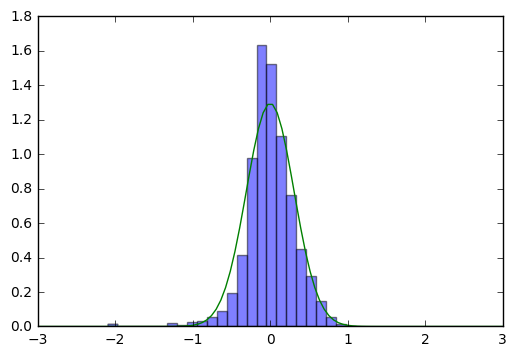

In [73]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

plt.hist(residuals, bins=25, normed=True, alpha=.5)
mu = residuals.mean()
variance = residuals.var()
sigma = residuals.std()
x = np.linspace(-3, 3, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
;

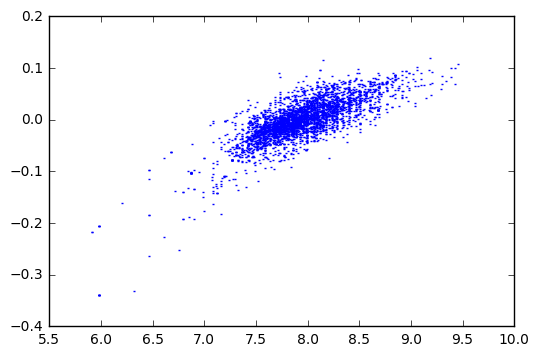

In [85]:
plt.scatter(np.log(sfbay['rent']), residuals/np.log(sfbay['rent']), marker=0, s=2, c='b')

In [68]:
residuals.mean()
residuals.std()

0.307922066769831

In [59]:
mod = sm.WLS(y, X, weights=1.)
res = mod.fit()
print(res.summary())

                            WLS Regression Results                            
Dep. Variable:           np.log(rent)   R-squared:                       0.372
Model:                            WLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     1231.
Date:                Thu, 17 Nov 2016   Prob (F-statistic):               0.00
Time:                        21:14:10   Log-Likelihood:                -1000.7
No. Observations:                4154   AIC:                             2007.
Df Residuals:                    4151   BIC:                             2026.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        3.6585      0.125     29.211   

In [27]:
from pymc3 import Model, NUTS, sample
from pymc3.glm import glm

with Model() as model_glm:
    glm('np.log(rent) ~ np.log(sqft) + bedrooms', sfbay)
    trace = sample(5000)

100%|██████████| 5000/5000 [01:11<00:00, 69.68it/s]


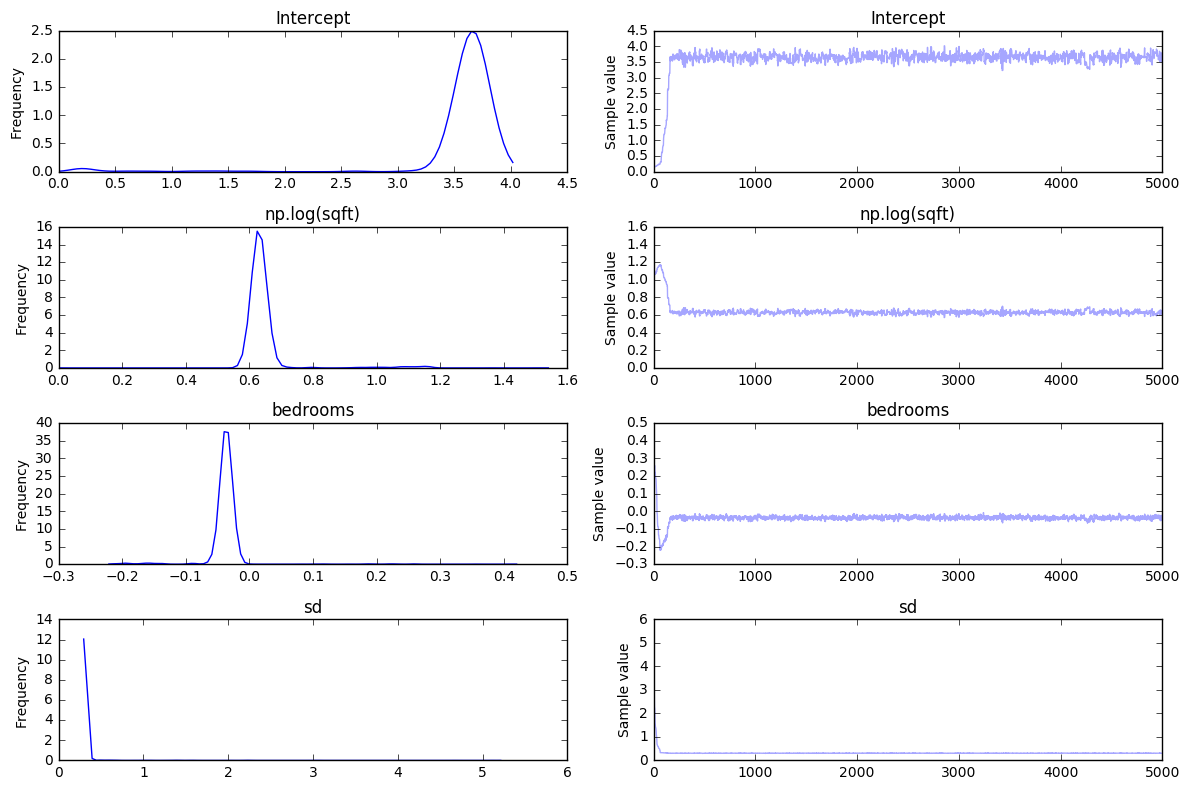

In [32]:
from pymc3 import traceplot
%matplotlib inline
traceplot(trace);

In [36]:
from scipy import optimize
from pymc3 import find_MAP
with model_glm:

    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # draw 2000 posterior samples
    trace = sample(5000, start=start)

Optimization terminated successfully.
         Current function value: 1048.874889
         Iterations: 22
         Function evaluations: 1063


100%|██████████| 5000/5000 [01:12<00:00, 69.22it/s]


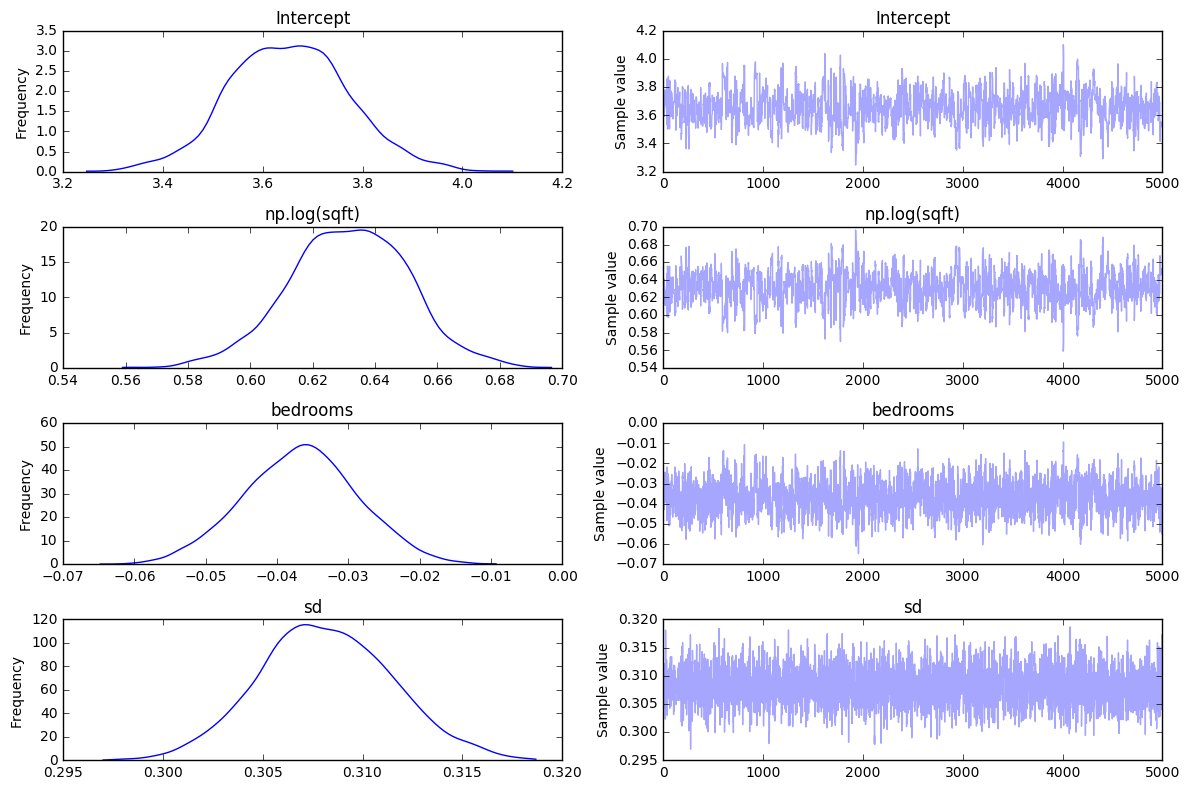

In [37]:
traceplot(trace);

In [48]:
import matplotlib.pyplot as plt
import theano
import pymc3 as pm

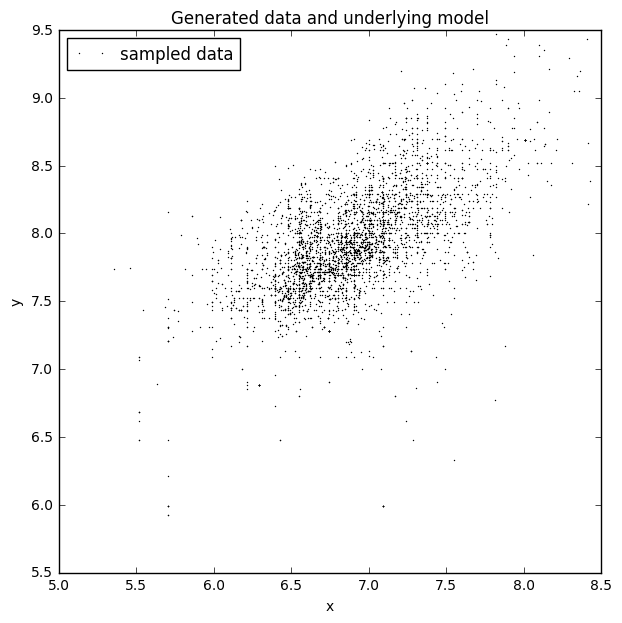

In [87]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(np.log(sfbay['sqft']), np.log(sfbay['rent']), 'o', markersize=.5, color='blue', label='sampled data')
#ax.plot(x, true_regression_line, label='true regression line', lw=2.)
#pm.glm.plot_posterior_predictive(trace, samples=100,
#                                 label='posterior predictive regression lines')
plt.legend(loc=0);